**Nota**: Para ejecutar las celdas de código de [esta notebook](https://www.kaggle.com/code/karensnchez/flower-classification-with-fastai-and-oxford102), puedes hacerlo en Kaggle seleccionando la opción "Copy & Edit". 

Este es mi *miniproyecto* de las lecciones 1 y 2 del curso [Practical Deep Learning for Coders part 1](https://course.fast.ai/).

En este curso se enfatiza que para sacar el máximo provecho de este tenemos que llevar a cabo miniproyectos en cada lección, ya que, como menciona Jeremy Howard, el profesor, "lo más importante para aprender Deep Learning es  escribir código y experimentar". 

Los miniproyectos se basan en lo que aprendimos durante la lección y los capítulos correspondientes del libro del curso. Pueden consistir en pequeñas modificaciones a la notebook principal, como probar arquitecturas diferentes a las presentadas o entrenar modelos con conjuntos de datos de nuestro interés.  

En este miniproyecto me he basado en la notebook de la lección 1, [Is it a bird?](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data), así como en los capítulos 1 y 2 del libro. Mi objetivo es crear un clasificador de imágenes con 102 categorías de flores utilizando un conjunto de datos que encontré en la [documentación de fast.ai](https://docs.fast.ai/data.external.html#datasets).
 
En la primera lección del curso de fast.ai  construimos un clasificador de imágenes que distingue entre imágenes de bosques y pájaros. Inspirada en dicho clasificador, decidí crear un clasificador de flores.  Así, la próxima vez que vea una flor que me encante pero no sepa su nombre, podré tomarle una foto y preguntarle a mi modelo. 

El conjunto de datos consta de más de 8000 imágenes de 102 tipos de flores comunes en el Reino Unido. La división del conjunto de datos en conjuntos de entrenamiento, validación y prueba, así como las etiquetas, se especifican en archivos de texto, como veremos a continuación. 

Para trabajar en Kaggle tenemos que actualizar la librería de fastai con `-Uqq`. 

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 

# El conjunto de datos

En la página [datasets](https://docs.fast.ai/data.external.html#datasets) de la documentación de fast.ai se encuentran varios conjuntos de datos famosos, entre los cuales se encuentra el de *FLOWERS*, que contiene un poco más de 8000 imágenes etiquetadas de 102 tipos de flores típicas en el Reino Unido. 

Este conjunto de datos puede descargarse rápidamente con las funciones `untar_data` y `URLs` de fastai. 

**Consejo**: ¿Cómo saber el nombre de la librería o módulo de fastai que necesitas para importar una función que te interese? En los tutoriales que vienen en  la documentación de fast.ai no encontré por ningún lado cómo importar `untar_data`. Descubrí que si damos con esta función en el repositorio de fastai en GitHub, por ejemplo, el código de esta función se encuentra [aquí](https://github.com/fastai/fastai/blob/master/fastai/data/external.py#L126), que, como podemos corroborar, tiene la dirección que se muestra en la imagen de abajo, para determinar el módulo que contiene la función `untar_data` reemplazamos `/` por un punto, `.`, en la parte resaltada en amarillo, como se muestra en la celda siguiente.




Para encontrar la ubicación de la función `untar_data` escribí este término en la barra de búsqueda de GitHub con el filtro `repo:fastai/fastai`, como se muestra en la imagen de abajo: 

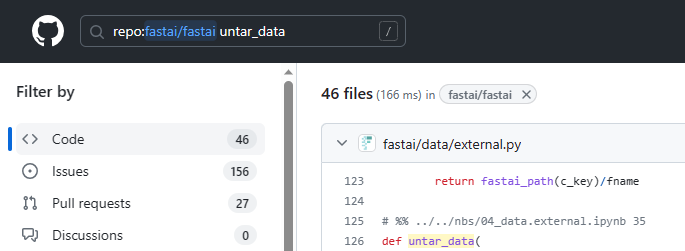

In [2]:
from fastai.data.external import untar_data, URLs

path = untar_data(URLs.FLOWERS)
path.ls()

(#4) [Path('/root/.fastai/data/oxford-102-flowers/jpg'),Path('/root/.fastai/data/oxford-102-flowers/test.txt'),Path('/root/.fastai/data/oxford-102-flowers/valid.txt'),Path('/root/.fastai/data/oxford-102-flowers/train.txt')]

Observamos que se descargaron 4 cosas: el directorio `jpg` y tres archivos de texto. Veamos qué información contienen estos últimos:

In [3]:
!head '/root/.fastai/data/oxford-102-flowers/train.txt'

jpg/image_03860.jpg 16
jpg/image_06092.jpg 13
jpg/image_02400.jpg 42
jpg/image_02852.jpg 55
jpg/image_07710.jpg 96
jpg/image_07191.jpg 5
jpg/image_03050.jpg 91
jpg/image_07742.jpg 96
jpg/image_06523.jpg 25
jpg/image_05517.jpg 86


In [4]:
!head '/root/.fastai/data/oxford-102-flowers/valid.txt'

jpg/image_04467.jpg 89
jpg/image_07129.jpg 44
jpg/image_05166.jpg 4
jpg/image_07002.jpg 34
jpg/image_02007.jpg 79
jpg/image_02830.jpg 55
jpg/image_05373.jpg 21
jpg/image_01335.jpg 50
jpg/image_04652.jpg 47
jpg/image_07083.jpg 66


In [5]:
!head '/root/.fastai/data/oxford-102-flowers/test.txt'

jpg/image_06977.jpg 34
jpg/image_00800.jpg 80
jpg/image_05038.jpg 58
jpg/image_06759.jpg 0
jpg/image_01133.jpg 45
jpg/image_07982.jpg 100
jpg/image_04468.jpg 89
jpg/image_02363.jpg 42
jpg/image_01393.jpg 50
jpg/image_07216.jpg 6


En cada línea de los archivos de texto tenemos el nombre de una imagen precedido por el directorio `jpg`, seguido de un espacio en blanco y, finalmente, un número que representa la etiqueta codificada de la imagen. (Más adelante, en lugar de utilizar etiquetas codificadas, utilizaremos los nombres de las flores.) Por lo tanto, estos archivos de texto especifican cómo se realizará la división del conjunto de datos. 

En el directorio `jpg` se encuentran las imágenes que ocuparemos para entrenar y validar nuestro 
modelo. Además, este directorio tambien contiene un conjunto de prueba. Veamos cuántas imágenes hay en el directorio `jpg`. 

In [6]:
len(os.listdir(path/'jpg'))

8189

Observamos que tenemos más de 8000 imágenes de flores.

Podemos convertir los archivos de texto en `DataFrame`'s de pandas para investigar más acerca de nuestro conjunto de datos. Por ejemplo, ¿cuántas imágenes se usarán para entrenar el modelo?, ¿cuántas se usarán para la validación? Asimismo podemos corroborar que tenemos 102 categorías de flores y averiguar cuántas imágenes hay por categoría. Todo esto se puede hacer rápidamente si convertimos los archivos de texto a `DataFrame`'s.

In [7]:
import pandas as pd

cols=['filename','label']
train=pd.read_csv(path/'train.txt', sep=" ", names=cols)
train.head()

,filename,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


In [8]:
print(f"El conjunto de entrenamiento cuenta con {train.filename.nunique()} imágenes.")

El conjunto de entrenamiento cuenta con 1020 imágenes.


In [9]:
print(f"El número de categorías que hay en el conjunto de entrenamiento es {train.label.nunique()}.")

El número de categorías que hay en el conjunto de entrenamiento es 102.


In [10]:
print(f"El número de imagenes que hay por categoría es {train.groupby('label').filename.nunique().unique()}")

El número de imagenes que hay por categoría es [10]


Lo cual sí cuadra, pues si son 102 categorías cada una con 10 imagenes, eso nos da las 1020 imágenes que hay en el conjunto de entrenamiento.

Hacemos lo mismo con el conjunto de validación y prueba: 

In [11]:
valid=pd.read_csv(path/'valid.txt', sep=" ", names=cols)
valid.head()

,filename,label
0,jpg/image_04467.jpg,89
1,jpg/image_07129.jpg,44
2,jpg/image_05166.jpg,4
3,jpg/image_07002.jpg,34
4,jpg/image_02007.jpg,79


In [12]:
print(f"El conjunto de validación cuenta con {valid.filename.nunique()} imágenes.")
print(f"El número de categorías que hay en conjunto de validación es {valid.label.nunique()}.")
print(f"El número de imagenes que hay por categoría es {valid.groupby('label').filename.nunique().unique()}")

El conjunto de validación cuenta con 1020 imágenes.
El número de categorías que hay en conjunto de validación es 102.
El número de imagenes que hay por categoría es [10]


Observamos que cada una de las categorías se entrena y valida con 10 imágenes. 

In [13]:
test_df=pd.read_csv(path/'test.txt', sep=" ", names=cols)
test_df.head()

,filename,label
0,jpg/image_06977.jpg,34
1,jpg/image_00800.jpg,80
2,jpg/image_05038.jpg,58
3,jpg/image_06759.jpg,0
4,jpg/image_01133.jpg,45


In [14]:
print(f"El conjunto de prueba cuenta con {test_df.filename.nunique()} imágenes.")
print(f"El número de categorías que hay en conjunto de prueba es {test_df.label.nunique()}.")
print(f"El número de imagenes que hay por categoría es {test_df.groupby('label').filename.nunique().unique()}")

El conjunto de prueba cuenta con 6149 imágenes.
El número de categorías que hay en conjunto de prueba es 102.
El número de imagenes que hay por categoría es [ 20  40  36  45  25  65  26  67  29  28  21  62  39  71  22  46  58  32
  23  55  88  47 107 110  73 176  51  72 238  41  89  94  30  35  34  82
  42  76 174 151 100  87 231 117  85 146  92 111  66  43  38 134 164  56
 142 108]


Por otro lado, en el conjunto de prueba, el número de imágenes que hay por categoría es variable. A diferencia de los conjuntos anteriores, donde cada categoría constaba de 10 imágenes, en el conjunto de prueba algunas categorías tienen 20 imágenes, otras 40, otras 36, etc. 

## El conjunto de prueba

Por ahora, podemos prescindir del conjunto de prueba y solo apoyarnos del conjunto de validación para evaluar el desempeño del modelo. De hecho, el conjunto de prueba debe permanecer oculto para nosotros, los que estamos entrenando el modelo, y solo emplearse hasta que estemos satisfechos con los resultados que arroja nuestro modelo. No antes. El propósito del conjunto de prueba es verificar que la persona encargada de entrenar un modelo no haya cometido un sobreajuste en el conjunto de validación. Al igual que el modelo puede sobreajustarse al conjunto de entrenamiento, nosotros (los humanos) también podemos cometer sobreajuste en el conjunto de validación al tratar, de todas las formas posibles, de incrementar la precisión en dicho conjunto.

Por tanto, no hay problema si eliminamos este conjunto por ahora. Mi motivo para hacer esto es que más adelante uso la función `get_image_files`, a la cual debo pasar como argumento la ubicación del directorio `jpg`, para indicarle a fastai donde se encuentran los datos para entrenar y validar el modelo, pero si los datos del conjunto de prueba se encuentran en el directorio `jpg`, estos serán considerados datos de entrenamiento, lo cual sería erróneo. Sin embargo, si no deseamos eliminarlos podemos simplemente mover los archivos a un nuevo directorio, por ejemplo, con:  
```python
# Crear un nuevo directorio 

dest = path/'test_images'
dest.mkdir(exist_ok=True, parents=True)

# Mover los archivos de prueba al nuevo directorio
for filename in test_df['filename']:
    source_file=path/filename
    !mv $source_file $dest
```
**Advertencia**: Este bloque de código tarda aproximadamente 0.5 h en ejecutarse en mi computadora.

He optado por eliminar las imágenes del conjunto de prueba en lugar de moverlos a un nuevo directorio, porque la primera opción es mucho más rápida. 

**Nota**: El inconveniente de tener que eliminar o mover los datos del conjunto de prueba surge debido al uso de la función `get_image_files` al crear el`DataBlock`. Sin embargo, existen otras formas de indicarle a fastai cómo obtener los datos de entrenamiento y validación que no requieren implementar cambios en el directorio `jpg`. Puedes observar un ejemplo de estas alternativas [aquí](https://www.kaggle.com/code/hobaak/flowerdetector-oxford-102-flowers), donde se utiliza el mismo conjunto de datos que yo he usado.  

In [15]:
# Ocupamos este modulo para usar la clase Path, la función `doc`, etc
from fastai.vision.all import *

deleted=list(map(Path.unlink, test_df['filename'].apply(lambda x: path/x)))
print(f"El número total de archivos eliminados del directorio jpg es {len(deleted)}")
print(f"Ahora el directorio jpg solo cuenta con {len(os.listdir(path/'jpg'))} imágenes")

El número total de archivos eliminados del directorio jpg es 6149
Ahora el directorio jpg solo cuenta con 2040 imágenes


Vemos que en el directorio `jpg` nos hemos quedado con las imágenes de entrenamiento y validación.


# Creación del `DataBlock` y los `dataloaders`.

## ¿Qué es un `DataBlock` y que son los `dataloaders`?

Como Jeremy Howard menciona en la lección 1, "Si hay algo que debe preocuparnos como novatos es aprender a usar los `DataBlocks`. Ni entender qué es una red neuronal es tan importante en la práctica". Lo primero se refiere a que sin datos no podemos entrenar un modelo. Lo segundo se refiere a que en la actualidad la comunidad de Deep Learning cuenta con modelos que pueden resolver casi cualquier tarea que nos imaginemos, es decir, no es necesario entrenar una red neuronal desde cero.  Ojo: En este curso nos dicen qué es más importante en la práctica, por algo se llama **PRACTICAL** Deep Learning for Coders.


El **`DataBlock`**  es una plantilla que tenemos que rellenar y sirve no solo para problemas de Computer Vision, sino que también funciona para otro tipo de tareas. Diferentes tipos de tareas comparten elementos comunes, como especificar los datos de entrada y la variable objetivo, la ubicación de los datos, cómo asignar etiquetas y cómo crear nuestro conjunto de validación. El único requisito especial para Computer Visión es que todas las imágenes deben tener el mismo tamaño. 

Sin embargo, un `DataBlock` no hace nada hasta que no definimos los `dataloaders`, que es donde tendremos guardados los datos listos para comenzar el entrenamiento del modelo. 

Antes de crear nuestro `DataBlock` y nuestros `dataloaders` me gustaría hablar de las funciones que he utilizado en los parámetros del `DataBlock`, que, como veremos más adelante, está definido de la siguiente manera:
```python
flowers=DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y= get_flower_name,
    splitter=FuncSplitter(is_valid),
    item_tfms=Resize(460))
````
Lo primero que le debemos de decir a fastai el tipo de problema que estamos resolviendo, en este caso, clasificación de imagenes, por tanto, el primer parametro del `DataBlock` es:
## *Inputs* y *outputs* del modelo
`blocks=(ImageBlock, CategoryBlock)`: En esta parte indicamos cuál es el *input* y cuál es *output*. En este caso, por tratarse de clasificación de imágenes, cuando mi modelo haga predicciones, el input que le voy a dar es una imagen y lo que el modelo me tiene que regresar es la etiqueta o categoría de esta imagen.
## ¿Dónde están los datos?
`get_items=get_image_files`: Aquí le decimos a fastai donde se encuentran los datos, donde hemos utilizado la función `get_image_files`, que conviene que revisemos un poco qué hace. 


In [16]:
get_image_files(path/'jpg')

(#2040) [Path('/root/.fastai/data/oxford-102-flowers/jpg/image_05046.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_07694.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_07564.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_01324.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_07225.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_04721.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_04855.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_06682.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_00719.jpg'),Path('/root/.fastai/data/oxford-102-flowers/jpg/image_04952.jpg')...]

**Nota**: Observemos que le he dado como argumento la dirección donde se encuentran las imágenes, mientras que en mi DataBlock no lo hice. Esto es porque la fuente de los datos la especifico cuando creo los dataloaders, después de crear el `DataBlock`.

`get_image_files` extrae las direcciones de todas las imágenes en el folder `jpg` de forma recursiva, esto es, incluye las de las imágenes en los subfolders, si es que hay. Esta es la razón por la que tuvimos que eliminar las imágenes del conjunto de prueba de este directorio, ya que también serían utilizadas como datos para entrenar nuestro modelo. 

Lo que esta función nos proporciona como *items* son las direcciones de  todas las imagenes que tenemos en el directorio `jpg` (2040 en total). 

In [17]:
type(Path('/root/.fastai/data/oxford-102-flowers/jpg/image_05046.jpg'))

pathlib.PosixPath

Obsevamos que el tipo de objeto de cada item es un objeto archivo, `pathlib.PosixPath`.  Este tipo de objetos tienen la propiedad `.name`, que nos da el último componente de una dirección, esto es, el nombre del archivo. Por ejemplo:

In [18]:
Path('/root/.fastai/data/oxford-102-flowers/jpg/image_05046.jpg').name

'image_05046.jpg'

De aquí en adelante, recordemos que los items son objetos `pathlib.PosixPath`, ya que nuestras definiciones para las funciones que dividen el conjunto de datos y que etiquetan las imágenes consideran esto, en concreto la propiedad `.name` de estos.


## Conjunto de validación

In [19]:
def is_valid(x): return valid['filename'].str.contains(x.name).any()

La función `is_valid` se usa para determinar qué *items* pertencen al conjunto de validación. Recibe como input un objeto archivo. Revisa si en las cadenas de la columna `filename` del dataframe `valid`, hay una subcadena que coincide con el nombre del archivo, `x.name`, por lo que sus resultados son `True` o `False`.  

`splitter=FuncSplitter(is_valid)`: Llama a la función `is_valid` y se encarga dividir el conjunto de datos en base a los resultados de`is_valid`.  Si es `True`, entonces el *item* se envía a los dataloaders del conjunto de validación. De otra manera, el *item* se envía a los dataloaders del conjunto de entrenamiento. 

## Etiquetas



Lo bueno de computer vision es que podemos ver que tan buenas son las predicciones tan solo con ver la imagen y su predicción, por lo tanto sería de mayor utilidad para hacer esta inspección si tenemos como etiquetas los nombres de las flores, en lugar de etiquetas codificadas. 

In [20]:
# Source: https://www.kaggle.com/datasets/hobaak/oxford-102-flower-name-index

flowers_name=pd.read_csv('/kaggle/input/oxford-102-flower-name-index/oxford_flower_102_name.csv')
name_dict = flowers_name.set_index('Index').to_dict()['Name']
print(name_dict)

{0: 'pink primrose', 1: 'hard-leaved pocket orchid', 2: 'canterbury bells', 3: 'sweet pea', 4: 'english marigold', 5: 'tiger lily', 6: 'moon orchid', 7: 'bird of paradise', 8: 'monkshood', 9: 'globe thistle', 10: 'snapdragon', 11: "colt's foot", 12: 'king protea', 13: 'spear thistle', 14: 'yellow iris', 15: 'globe-flower', 16: 'purple coneflower', 17: 'peruvian lily', 18: 'balloon flower', 19: 'giant white arum lily', 20: 'fire lily', 21: 'pincushion flower', 22: 'fritillary', 23: 'red ginger', 24: 'grape hyacinth', 25: 'corn poppy', 26: 'prince of wales feathers', 27: 'stemless gentian', 28: 'artichoke', 29: 'sweet william', 30: 'carnation', 31: 'garden phlox', 32: 'love in the mist', 33: 'mexican aster', 34: 'alpine sea holly', 35: 'ruby-lipped cattleya', 36: 'cape flower', 37: 'great masterwort', 38: 'siam tulip', 39: 'lenten rose', 40: 'barbeton daisy', 41: 'daffodil', 42: 'sword lily', 43: 'poinsettia', 44: 'bolero deep blue', 45: 'wallflower', 46: 'marigold', 47: 'buttercup', 48:

In [21]:
train['flower_name']=train['label'].map(name_dict)
valid['flower_name']=valid['label'].map(name_dict)

In [22]:
train.head()

,filename,label,flower_name
0,jpg/image_03860.jpg,16,purple coneflower
1,jpg/image_06092.jpg,13,spear thistle
2,jpg/image_02400.jpg,42,sword lily
3,jpg/image_02852.jpg,55,bishop of llandaff
4,jpg/image_07710.jpg,96,mallow


In [23]:
valid.head()

,filename,label,flower_name
0,jpg/image_04467.jpg,89,canna lily
1,jpg/image_07129.jpg,44,bolero deep blue
2,jpg/image_05166.jpg,4,english marigold
3,jpg/image_07002.jpg,34,alpine sea holly
4,jpg/image_02007.jpg,79,anthurium


In [24]:
import pathlib

#Función que extrae las etiquetas de objetos tipo PosixPath.
def get_flower_name(o):
    assert isinstance(o, pathlib.PosixPath)
    if valid['filename'].str.contains(o.name).any():
        return valid[valid['filename'].str.contains(o.name)].flower_name.iloc[0] 
    else: 
        return train[train['filename'].str.contains(o.name)].flower_name.iloc[0] 

`assert isinstance(o, pathlib.PosixPath)` lo único que hace es corroborar que el input es un objeto `pathlib.PosixPath`.  

`get_y= get_flower_name`:  Le podemos pasar cualquier función a `get_y` que obtenga la etiqueta de cada item. Por ejemplo, en esta función primero verificamos a qué conjunto de datos pertenece el item, para lo cual buscamos si el nombre del archivo (`o.name`) es una subcadena de las cadenas en `filename` del dataframe`valid` o `train`. Una vez que sabemos en qué dataframe se encuentra la información de dicho item, lo ubicamos en el dataframe correspondiente y obtenemos el valor de la `flower_name` para este item.

In [25]:
get_flower_name(Path('/root/.fastai/data/oxford-102-flowers/jpg/image_05046.jpg'))

'orange dahlia'

Comprobamos que esta función devuelve etiquetas, para lo cual le dimos un ejemplo del tipo de  items que reciibirá cuando se creen los dataloaders.

## Las imágenes deben tener el mismo tamaño

Al entrenar nuestro modelo con una GPU, la computadora no ve imagen por imagen, sino que ve un montón de imágenes a la vez, a lo que se conoce como *batch*. Este grupo de imágenes se almacena en un arreglo, llamado tensor, por lo que cada imagen debe tener el mismo tamaño. 

`item_tfms = Resize(460)`: `item_tfms` son *item transforms*, una operación  o pedazo de código que se aplica a cada elemento o *item*. Un ejemplo de estos *transforms*  es `Resize`.     
`Resize(460)` Ajusta el tamaño de las imágenes al tamaño de 460 píxeles . El método por default que usa para ajustar el tamaño es crop, que recortar la imagen en forma de cuadro del tamaño especificado. Otros métodos para ajustar el tamaño de una imagen son squish y pad, para probarlos sustituimos `Resize(460)` por `Resize(460, ResizeMethod.Squish)` y `Resize(128, ResizeMethod.Pad,pad_mode='zeros')`, respectivamente.

### ¿Por qué 460 píxeles? 
Podemos elegir el tamaño que deseemos pero tenemos que considerar que:
* Con imágenes grandes, el modelo puede capturar más detalles de la imagen, por ende, el modelo tendrá mejores resultados. Sin embargo, las desventajas son que se requiere más memoria y recursos computacionales, lo que puede resultar en una menor velocidad de entrenamiento.

* Con imágenes pequeñas, se reducen los detalles de las misma, pero requieren menos memoria y recursos, lo que puede acelerar el entrenamiento.


In [26]:
flowers=DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y= get_flower_name,
    splitter=FuncSplitter(is_valid),
    item_tfms=Resize(460))

dls=flowers.dataloaders(path/'jpg', bs=32) 


El argumento que le damos a `dataloaders` es la fuente donde se encuentran las imágenes y `bs=32`, que significa que el número de imágenes que contiene un batch es 32. 

Para asegurarnos que nuestros dataloaders se formaron correctamente podemos verificar el número de datos que hay en cada dataloader, con esto además verificamos si nuestra función para dividir el conjunto de datos trabaja de acuerdo a lo esperado.


In [27]:
print(f"El número de batches en el dataloader de validación es: {len(dls.valid)}")

El número de batches en el dataloader de validación es: 32


Este resultado es el número de batches que hay en el dataloader de validación. Recordemos que en cada batch tenemos 32 imágenes (`bs=32`). Por lo tanto, en el conjunto de validación tenemos 32x32=1024 datos.

In [28]:
print(f"El número de batches en el conjunto de entrenamiento es: {len(dls.train)}")

El número de batches en el conjunto de entrenamiento es: 31


En cambio, en el conjunto de entrenamiento tenemos 31x32=992 datos.

Podemos ver que los conjuntos no contienen cada uno las 1020 imágenes que se supone debe haber en cada conjunto. El número de imágenes usadas fue: 992+1024=2016 de 2040 imágenes disponibles, por ende, se están desperdiciando 24 imágenes. Esto es producto del tamaño que elegimos para los batch, `bs=32`, ya que 1020 (número de imagenes destinadas para cada dataloader) no es múltiplo de 32. Debido a que sin excepción, cada batch debe estar formado con 32 imágenes, fastai hizo lo mejor que pudo para tener batchs de ese tamaño y desperdiciar el menor número de imagenes posibles, pues si en ambos dataloaders hubiesen 32 batches, rebasaríamos el número total de imágenes y si ambos dataloaders tuvieran 31 batches, se estarían desperdiciendo más imagenes de las que están desperdiciando ahora.  

Respecto a las imágenes que no están siendo utilizadas me pregunto cómo podremos saber a qué categoría pertenecen, si es una imagen por categoría o si se han quitado todas las imágenes de más de dos categorías (recordemos que cada categoría se entrena con 10 imágenes). Esto es importante porque debido a esta disminución de datos el modelo podría tener poca confianza en las predicciones de algunas categorías.


**Consejo**: Tenemos que elegir un tamaño de batch que emplee la mayoría, sino todas, las imágenes. En mi caso, funcionaría cualquier divisor de 1020 (por ejemplo, 30).


También podemos inspeccionar que nuestra función para etiquetar imágenes y que el diccionario que mapea los índices con el nombre de las flores están trabajando correctamente mostrando un batch, como sigue: 


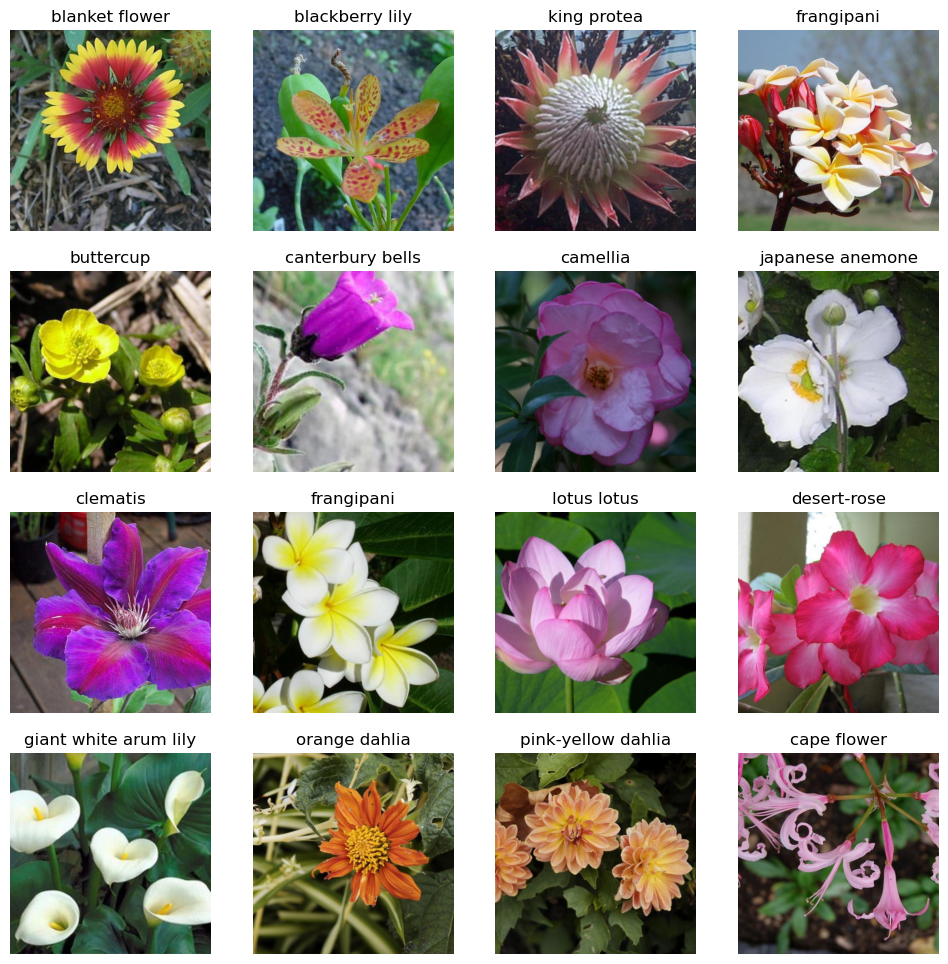

In [29]:
dls.show_batch(max_n=16)

Con una búsqueda rapida en la web podemos verificar que las flores que se muestran arriba coinciden con el nombre que se les da. Por lo que alcance a ver, todo marcha bien. 

# Entrenamiento del modelo 

In [30]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 32.0MB/s]


`vision_learn` combina el *modelo preentrenado* `resnet18`  y los datos, que están en los dataloaders. Aquí también se establece la *métrica*. 


## Modelos
En general, en Machine Learning un *modelo*  es igual a una arquitectura más un conjunto de parámetros entrenados. Un modelo, cuando termina de entrenarse, es lo mismo que los  programas típicos de computadora, ya que recibe un input (por ejemplo, una imagen) y nos devuelve un resultado (la etiqueta predicha). Por ejemplo, `resnet18` es un modelo cuya arquitectura o función matemática es una red neuronal, mientras que sus parametros entrenados son los que se obtuvieron de entrenar en el conjunto de datos ImageNet, toda está información puede consultarse [aquí](https://paperswithcode.com/lib/timm/resnet).

## Métrica
`metrics=error_rate`. La métrica mide la calidad de las predicciones de un modelo usando un conjunto de validación. `error_rate` nos da el porcentaje de imágenes en el conjunto de validación que fueron etiquetadas incorrectamente.




## Modelos preentrenados 

Son modelos que han sido entrenados en conjuntos de datos enormes, como ImageNet, que contiene más de 1 millón de imágenes de alrededor de 1000 categorías diferentes. Podemos aprovechar el conocimiento general que han adquirido, por ejemplo, para modelos preentrenados en imágenes, podemos beneficiarnos de su capacidad para reconocer patrones y características visuales en tareas similares a aquellas para las que fueron originalmente entrenados. Esto nos ahorra el tiempo que tomaría entrenar una red neuronal desde cero. Además, otra gran ventaja es que para personalizar el modelo preentrenado para nuestro problema no se requiere una cantidad tan grande de datos. Por ejemplo, en [Is it bird?](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data/notebook) se usaron ¡30 imágenes para cada categoría!

El modelo preentrenado que estamos usando, `resnet18`, fue entrenado para resolver una tarea similiar, aunque no exactamente igual a la nuestra, ya que ambas implican clasificación de imágenes. Dado que el modelo preentrenado fue entrenado para realizar una tarea diferente a la que estamos abordando, necesitamos aplicar una técnica conocida como *transfer learning* para adaptar el modelo preentrenado a nuestra tarea específica.

In [31]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,5.644185,2.874754,0.652941,00:25


epoch,train_loss,valid_loss,error_rate,time
0,3.068787,2.352395,0.528431,00:22
1,2.514914,1.718902,0.372549,00:21
2,1.851037,1.191888,0.253922,00:22
3,1.279319,0.913255,0.201961,00:22
4,0.841372,0.735211,0.152941,00:22
5,0.554581,0.648134,0.140196,00:21
6,0.365206,0.595047,0.138235,00:22
7,0.244178,0.561940,0.124510,00:22
8,0.166631,0.528423,0.122549,00:21
9,0.114712,0.517312,0.120588,00:22


`fine_tune`: Su argumento es el número de epochs, esto es, el número de veces que el modelo ve nuestros datos. Daremos más detalles sobre esta función más adelante. 

Cuando usamos un modelo preentrenado, tenemos que cortar las últimas capas de la red neuronal de dicho modelo, porque en dichas capas se encuentra el conocimiento específico de la tarea para la que originalmente fue entrenado. Cuando menciono "conocimiento específico", me refiero a los elementos únicos que distinguen al objeto objetivo de nuestra tarea.  Por ejemplo, si nuestra tarea es reconocer perros en imágenes, los elementos únicos podrían ser la naríz, el hocico, las patas y la silueta del perro. Por otro lado, si estamos tratando de distinguir imágenes de flores, los elementos únicos podrían ser los tallos, las hojas, los pétalos y su densidad. Sin embargo, para que la red neuronal llegue a reconocer estas figuras complejas comienza por aprender, en las capas iniciales de la red neuronal, los elementos generales de cualquier imagen, como rectas, círculos, esquinas, gradientes de colores, y poco a poco va conectando estos elementos, conforme van aumentando las capas de una red neuronal, hasta reconocer figuras complejas, como la forma del hocico de un perro o la estructura de los petalos de un flor. El libro ofrece una excelente visualización de lo que una red neuronal de 5 capas aprende en cada capa, en la subsección "What Our Image Recognizer Learned" del capítulo 1.

Después de cortar las capas finales del modelo preentrenado se añaden nuevas capas a la red, con pesos aleatorios, y el número de capas dependerá del tamaño de nuestro conjunto de datos. Estas nuevas capas se denominan *cabeza* del modelo. 

Para adaptar el modelo preentrenado a nuestra tarea específica, aplicamos una técnica conocida como *transfer learning*.

### Transfer Learning

Es el proceso de usar un modelo preentrenado, por todo lo que esté ya sabe hacer, para resolver una tarea diferente a la que fue entrenado originalemente. En el caso de clasificación de imágenes, como mencionamos anteriormente, nos interesa que el modelo preentrenado tenga conocimiento de los elementos esenciales de cualquier imagen, pero no estamos interesados en el conocimiento específico de las imágenes con las que fue originalmente entrenado. Esta técnica se lleva a cabo de la siguiente manera:

1. `vision_learner` se encarga de eliminar las últimas capas del modelo preentrenado y reemplazarlas por nuevas capas con pesos aleatorios. El número de capas que se añade depende del tamaño de nuestro conjunto de datos.

2. La función `fine_tune`, exclusiva de fastai, se encarga de adaptar nuestro conjunto de datos al modelo preentrenado:

    2.1  En el primer epoch, ajusta las partes del modelo para que la nueva cabeza aleatoria trabaje correctamente en nuestro conjunto de datos.
    
    2.2  Durante epochs solicitados, actualiza los pesos, especialmente los de la cabeza, mientras que los pesos de las capas iniciales casi no ocurre ningún cambio. 


Veamos qué tan bien lo hizo nuestro modelo con la matriz de confusión.

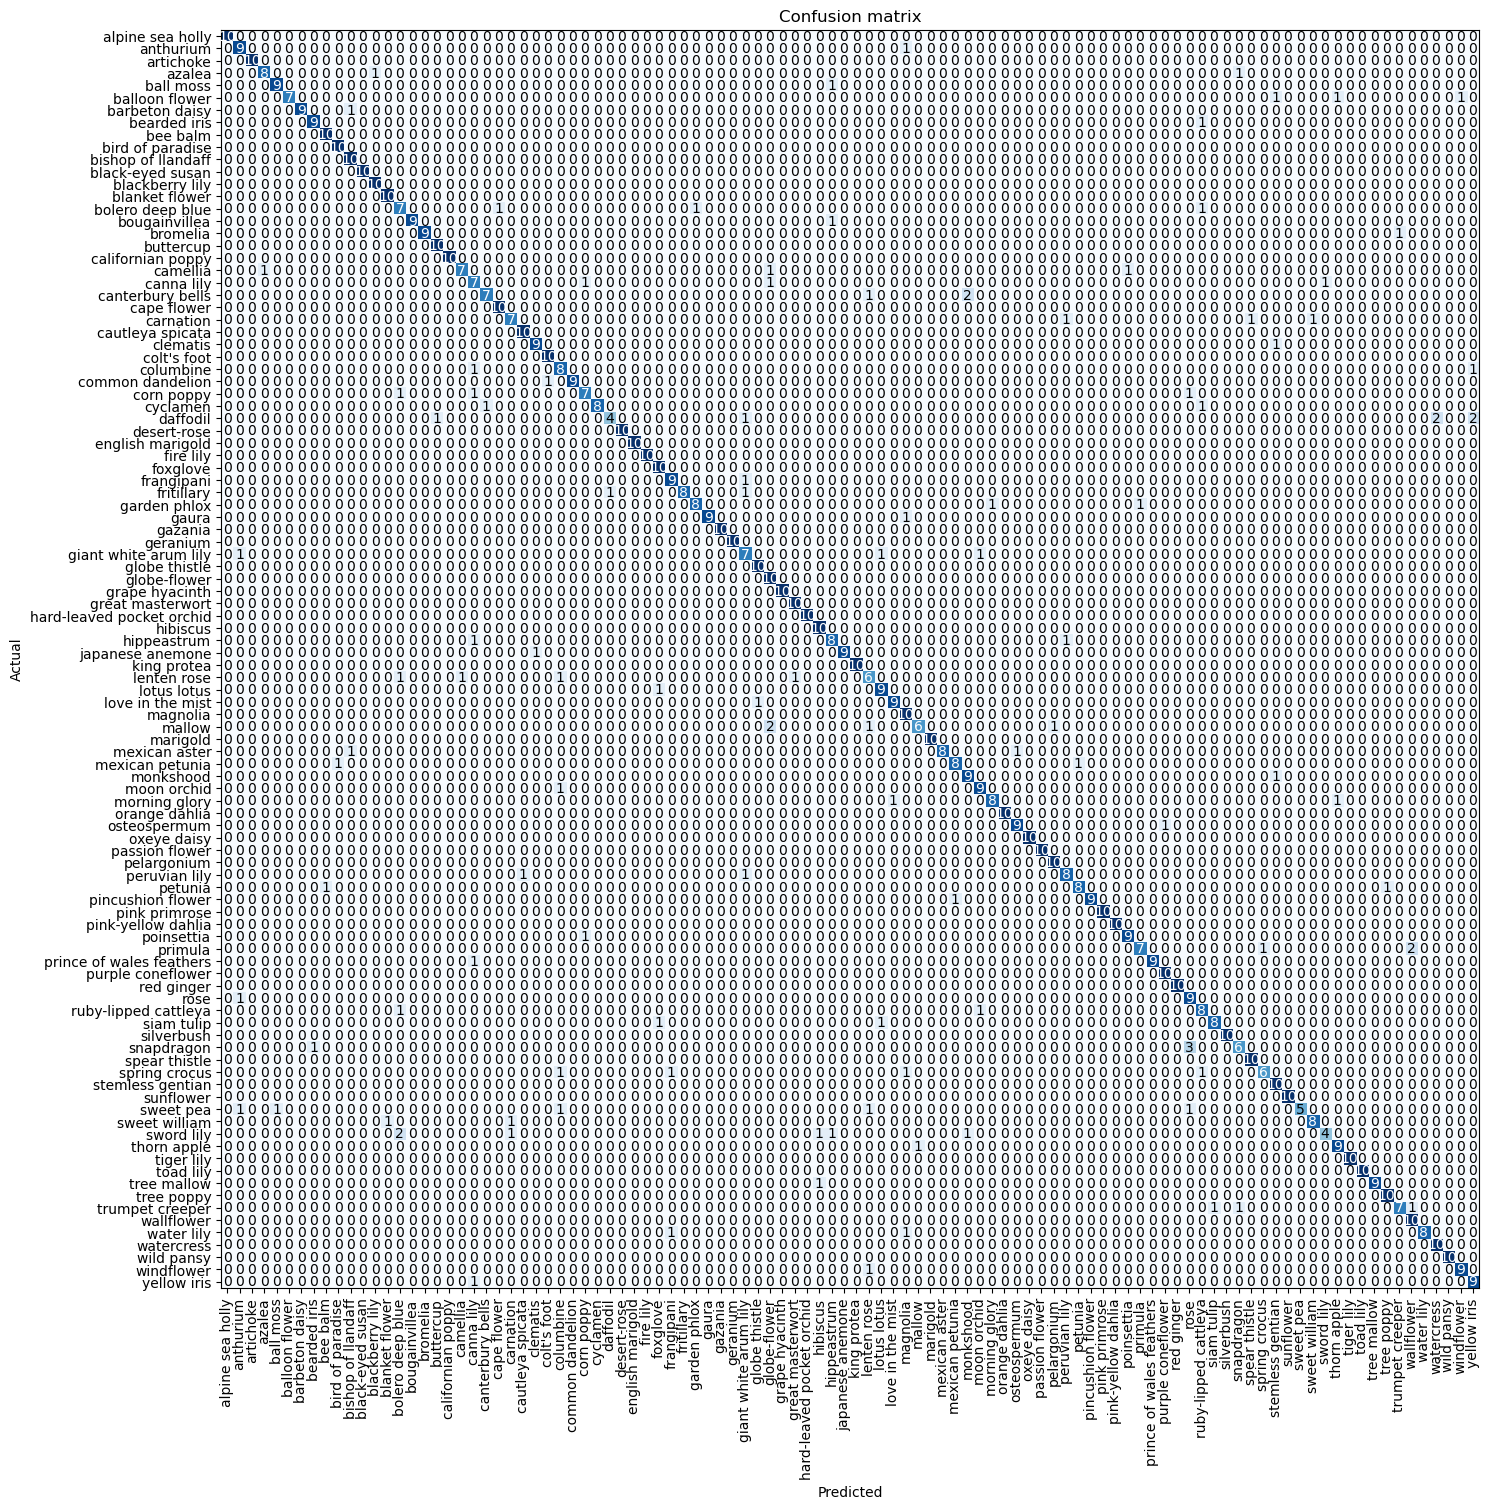

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(15, 15))

# Matriz de confusión 

El aspecto de la matriz de confusión de arriba indica que vamos por buen camino. Una matriz de confusión ideal tendría una diagonal en azul oscuro y los demás cuadritos en blanco, lo que significaría que nuestra precisión es del 100 %. 

La matriz de confusión nos ayuda a identificar las categorías en las que nuestro modelo está teniendo problemas para predecir y en las que predice correctamente con facilidad. Por ejemplo, podemos observar algunas categorías donde el modelo predijo correctamente 10/10 imágenes, pero también observamos otras en azul claro donde se predijo solo 5/10. Por ende, aún hay margen para mejorar nuestros resultados. 

Otra forma de ver donde está teniendo problemas nuestro modelo es viendo cuáles son las mayores pérdidas:


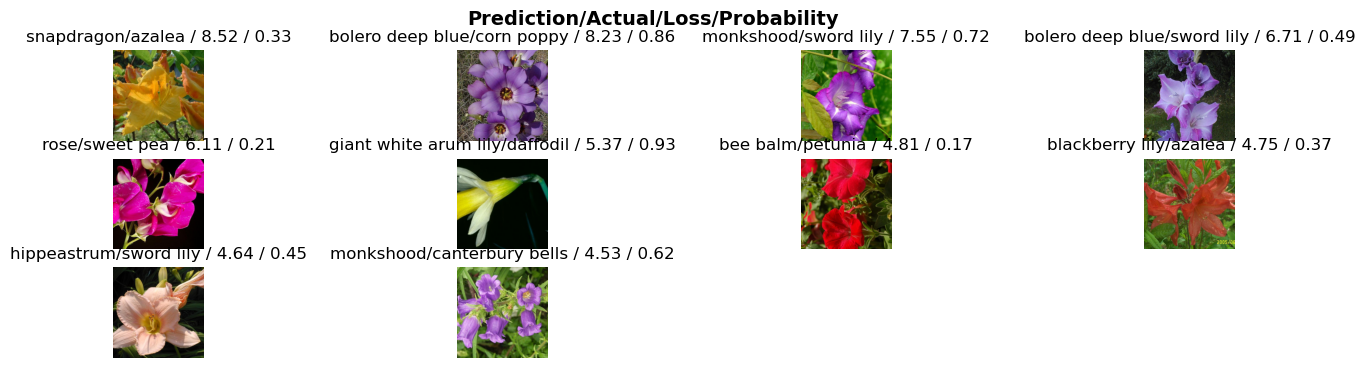

In [33]:
interp.plot_top_losses(10, nrows=3,figsize=(17,4))

Las pérdidas son grandes cuando el modelo predijo incorrectamente, cuando además de predecir incorrectamente estaba muy seguro (probabilidad alta) de su respuesta  o cuando predijo correctamente pero con poca seguridad (probabilidad baja).

# Predicciones


Para usar este modelo, recodermos que debemos estar en el modo "Edit" en Kaggle. Así, al ejecutar la celda siguiente, nos aparecerá el botón "Upload" para que puedas subir una foto de la flor que desees y el modelo pueda adivinar su nombre. 


In [34]:
import ipywidgets as widgets
from IPython.display import display

uploader = widgets.FileUpload(multiple=True)
uploader

FileUpload(value={}, description='Upload', multiple=True)

Después de haber subido tu imagen, ejecuta la siguiente celda y podrás obtener la predicción del modelo, así como la probabilidad o el nivel de confianza que tiene el modelo sobre su respuesta. 

```python
im = uploader.data[0]
categoria, indice, probabilidades = learn.predict(im)
print(f"Probability it's a {categoria}: {probabilidades[indice]:.4f}")
```

**¡Ojo!**: Recuerda que el modelo solo reconoce 102 tipos de flores, así que es mejor elegir una imagen de una flor que esté en esa lista para que el modelo no pase un mal rato. ¡Diviértete probándolo!